In [1]:
import os
import re
import matplotlib.pyplot as plt
import numpy as np

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType, FloatType
from __future__ import print_function, unicode_literals, with_statement, absolute_import, generators, nested_scopes, division
%matplotlib inline 

In [2]:
# Local Spark
# spark session is now the entry point of spark program
# for line 8, can use local[n] for run spark locally with n cores
spark = SparkSession.builder \
    .master('local') \
    .appName('Spark Try') \
    .getOrCreate()

In [3]:
#interactive nodes

# # start spark master program on this machine and register worker nodes
# os.system('start-spark-slurm.sh&') # use & to put it into background

# # get ip address of this machine
# ip = os.popen('hostname -i').read().strip('\n')
# print 'Spark Master web UI: http://{}:8080'.format(ip)
   
# # get ip address of master node (current machine)
# ip = os.popen('hostname -i').read().strip('\n')

# # change 'local' to be ip of master node
# spark = SparkSession.builder \
#     .master('spark://' + ip + ':7077') \
#     .appName('Spark Try') \
#     .getOrCreate()
# print 'Spark Session web UI: http://{}:4040'.format(ip)

In [4]:
df = spark.read.json('/project/cmsc25025/sou/speeches.json')

In [5]:
df.show()

+--------------------+--------------------+----+
|           president|                text|year|
+--------------------+--------------------+----+
|        James Monroe| Fellow-Citizens ...|1821|
|    William McKinley| To the Senate an...|1897|
|Dwight D. Eisenhower|[Delivered in per...|1960|
|     Calvin Coolidge|Since the close o...|1923|
|       James Madison| Fellow-Citizens ...|1816|
|    Grover Cleveland| To the Congress ...|1886|
|   John Quincy Adams| Fellow Citizens ...|1827|
|  Theodore Roosevelt| To the Senate an...|1905|
|   Lyndon B. Johnson|Mr. Speaker, Mr. ...|1965|
|       James K. Polk| Fellow-Citizens ...|1848|
|      Woodrow Wilson|Gentlemen of the ...|1913|
|Dwight D. Eisenhower|[Delivered in per...|1955|
|         George Bush|Mr. President and...|1991|
|     Franklin Pierce| Fellow-Citizens ...|1856|
...|1944|
|   Lyndon B. Johnson|[Delivered in per...|1968|
|      Andrew Johnson| Fellow-Citizens ...|1867|
|      Woodrow Wilson|GENTLEMEN OF THE ...|1914|
|      Har

# (a) Parse texts into sentences

In [6]:
#df = df.withColumn("Sentences", df.rdd.map(lambda x: re.split('\. [A-Z]', x['text'])).collect())
df.rdd.map(lambda x: x['text']).collect()[0]

u' Fellow-Citizens of the Senate and House of Representatives:\r\n\r\n \r\n\r\nThe progress of our affairs since the last session has been such as may justly be claimed and expected under a Government deriving all its powers from an enlightened people, and under laws formed by their representatives, on great consideration, for the sole purpose of promoting the welfare and happiness of their constituents. In the execution of those laws and of the powers vested by the Constitution in the Executive, unremitted attention has been paid to the great objects to which they extend.\r\n\r\nIn the concerns which are exclusively internal there is good cause to be satisfied with the result. The laws have had their due operation and effect.\r\n\r\nIn those relating to foreign powers, I am happy to state that peace and amity are preserved with all by a strict observance on both sides of the rights of each.\r\n\r\nIn matters touching our commercial intercourse, where a difference of opinion has existe

In [7]:
@udf
def split_sent(s):
    return re.split(r'\.\s+(?=[A-Z])', s)

@udf
def split_word(s):
    return re.split(r'\s+', s)

def div_(a,b):
    return a/b

count = udf(lambda s: len(s), IntegerType())
int_y = udf(lambda s: int(s), IntegerType())
div = udf(div_, FloatType())



In [8]:
def find_longest_len_(l):
    l_ = sorted(l, key =lambda x: x.count(' '))
    return l_[-1].count(' ')-1
find_longest_len = udf(find_longest_len_, IntegerType())

@udf
def find_longest_sent(l):
    l_ = sorted(l, key =lambda x: x.count(' '))
    return l_[-1]

def find_shortest_len_(l):
    l_ = sorted(l, key =lambda x: x.count(' '))
    return l_[0].count(' ')-1
find_shortest_len = udf(find_shortest_len_, IntegerType())

@udf
def find_shortest_sent(l):
    l_ = sorted(l, key =lambda x: x.count(' '))
    return l_[0]

# def find_longest_len_(l):
#     l_list = [(lambda x: re.split(r'\s+', x)) for x in l]
#     l_list = sorted(l_list, key =lambda x: len(x))
#     length = len(l_list[-1])
#     #sent = ' '.join(l_list[-1])
#     return length

# find_longest_len = udf(find_longest_len_, IntegerType())

# @udf
# def find_longest_sent(l):
#     l_list = [(lambda x: re.split(r'\s+', x)) for x in l]
#     l_list = sorted(l_list, key =lambda x: len(x))
#     sent = ' '.join(l_list[-1])
#     return sent

#df_b.select("longest_len", "longest_sent").sort("longest_len").toPandas()

In [9]:
df_a = df.withColumn("Sentences", split_sent(df.text))
df_a.show()

+--------------------+--------------------+----+--------------------+
|           president|                text|year|           Sentences|
+--------------------+--------------------+----+--------------------+
|        James Monroe| Fellow-Citizens ...|1821|[ Fellow-Citizens...|
|    William McKinley| To the Senate an...|1897|[ To the Senate a...|
|Dwight D. Eisenhower|[Delivered in per...|1960|[[Delivered in pe...|
|     Calvin Coolidge|Since the close o...|1923|[Since the close ...|
|       James Madison| Fellow-Citizens ...|1816|[ Fellow-Citizens...|
|    Grover Cleveland| To the Congress ...|1886|[ To the Congress...|
|   John Quincy Adams| Fellow Citizens ...|1827|[ Fellow Citizens...|
|  Theodore Roosevelt| To the Senate an...|1905|[ To the Senate a...|
|   Lyndon B. Johnson|Mr. Speaker, Mr. ...|1965|[Mr, Speaker, Mr,...|
|       James K. Polk| Fellow-Citizens ...|1848|[ Fellow-Citizens...|
|      Woodrow Wilson|Gentlemen of the ...|1913|[Gentlemen of the...|
|Dwight D. Eisenhowe

# (b)number of sentences, mean sentence lengths
For each year, compute the number of sentences in the address, and the mean sen- tence length in words for that year. Plot these data and two linear regressions, one plot for the number of sentences by year, another for the average sentence length by year. Note that the definition of “word” and “sentence” is imprecise. You can experi- ment with different parsing rules, and see if the results change qualitatively. Describe the trends that you see, and give some explanation for them.

In [10]:
df_b = df_a.withColumn("Sent_num", count(df_a.Sentences))
df_b = df_b.withColumn("Words", split_word(df_b.text))
df_b = df_b.withColumn("Word_num", count(df_b.Words))
df_b = df_b.withColumn("num_word_sent", div(df_b.Word_num, df_b.Sent_num))
df_b = df_b.withColumn("Year", int_y(df_b.year))

df_b = df_b.withColumn("longest_len", find_longest_len(df_b.Sentences))
df_b = df_b.withColumn("longest_sent", find_longest_sent(df_b.Sentences))
df_b = df_b.withColumn("shortest_len", find_shortest_len(df_b.Sentences))
df_b = df_b.withColumn("shortest_sent", find_shortest_sent(df_b.Sentences))

In [11]:
#df_b.show()

In [12]:
DF_b = df_b.groupBy('Year').mean('Sent_num', "num_word_sent").sort("Year").toPandas()

In [13]:
DF_b.insert(1, 'Ones', 1)
#DF_b[:10]

In [14]:
#Linear regression for number of sentences by year
X = np.matrix(DF_b.iloc[:, (1, 0)].values)
y = np.matrix(DF_b.iloc[:,2].values).transpose()
B = np.dot(np.dot(np.linalg.inv(np.dot(X.transpose(),X)),X.transpose()),y)
#B = np.dot(np.linalg.inv(np.dot(X.transpose(),X)),X.transpose())
y_hat = np.dot(X, B)

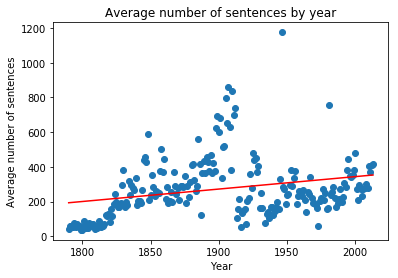

In [15]:
plt.scatter(DF_b['Year'], DF_b['avg(Sent_num)'])
plt.plot(DF_b['Year'], y_hat, color ='r')
#plt.legend()
plt.title("Average number of sentences by year")
plt.xlabel("Year")
plt.ylabel("Average number of sentences")

In [16]:
#Linear regression for average sentence length by year
X = np.matrix(DF_b.iloc[:, (1, 0)].values)
y = np.matrix(DF_b.iloc[:,3].values).transpose()
B = np.dot(np.dot(np.linalg.inv(np.dot(X.transpose(),X)),X.transpose()),y)
#B = np.dot(np.linalg.inv(np.dot(X.transpose(),X)),X.transpose())
y_hat = np.dot(X, B)

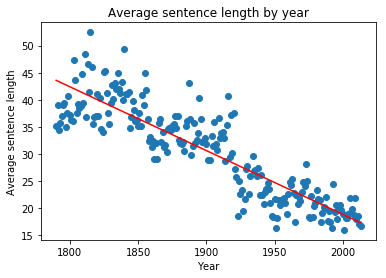

In [17]:
plt.scatter(DF_b['Year'], DF_b['avg(num_word_sent)'])
plt.plot(DF_b['Year'], y_hat, 'r')
plt.title("Average sentence length by year")
plt.xlabel("Year")
plt.ylabel("Average sentence length")

As year number increases, number of sentences increases slightly but the average number of words per sentence decreases significantly. These two trends might have shown that the language complexity of State of Union addresses has decreased over time. This might due to the fact that politics changed from an exclusive activity for elites to a practice for the public. (At least, there's a need to address to the public and get their support.)

# (c)
Now, compute two regressions of the total number of words in a SOU versus year–one for the years 1790 to 1912, another for the years 1913 to the present. What trends do you see? Lookup the history of the State of the Union addresses (for example on Wikipedia) to explain the regressions.

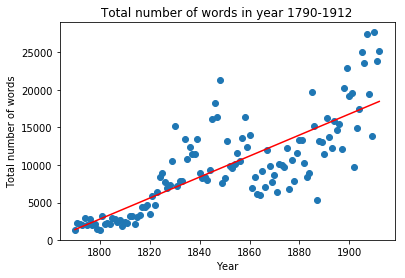

In [18]:
#Regression form year 1790 to 1912
DF_c1 = df_b.groupBy('Year').mean('Word_num').sort("Year").toPandas().iloc[:(1912-1790+1),:]
DF_c1.insert(1, 'Ones', 1)
#Linear regression for total number of words by year
X = np.matrix(DF_c1.iloc[:, (1, 0)].values)
y = np.matrix(DF_c1.iloc[:,2].values).transpose()
B = np.dot(np.dot(np.linalg.inv(np.dot(X.transpose(),X)),X.transpose()),y)
#B = np.dot(np.linalg.inv(np.dot(X.transpose(),X)),X.transpose())
y_hat = np.dot(X, B)

plt.scatter(DF_c1['Year'], DF_c1.iloc[:,2])
plt.plot(DF_c1['Year'], y_hat, 'r')
plt.title("Total number of words in year 1790-1912")
plt.xlabel("Year")
plt.ylabel("Total number of words")

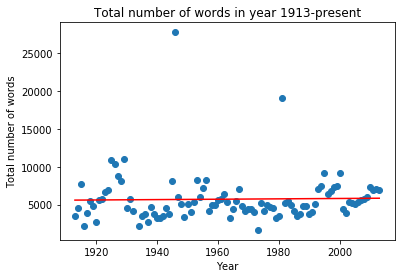

In [19]:
#Regression form year 1913 to present
DF_c2 = df_b.groupBy('Year').mean('Word_num').sort("Year").toPandas().iloc[(1912-1790+1):,:]
DF_c2.insert(1, 'Ones', 1)

#Linear regression for total number of words by year
X = np.matrix(DF_c2.iloc[:, (1, 0)].values)
y = np.matrix(DF_c2.iloc[:,2].values).transpose()
B = np.dot(np.dot(np.linalg.inv(np.dot(X.transpose(),X)),X.transpose()),y)
y_hat = np.dot(X, B)

plt.scatter(DF_c2['Year'], DF_c2.iloc[:,2])
plt.plot(DF_c2['Year'], y_hat, 'r')
plt.title("Total number of words in year 1913-present")
plt.xlabel("Year")
plt.ylabel("Total number of words")

According to Wiki, "George Washington delivered the first regular annual message before a joint session of Congress on January 8, 1790, in New York City, then the provisional U.S. capital. In 1801, Thomas Jefferson discontinued the practice of delivering the address in person, regarding it as too monarchical (similar to the Speech from the Throne); the address was written and then sent to Congress to be read by a clerk until 1913 when Woodrow Wilson re-established the practice (of presidents' personal address) despite some initial controversy." Thus, there's a trend of increasing number of words in the speech before 1913 due to the change from presidents' oral address to having a clerk read them. This also explains why there's a sharp drop from 1912 to 1913 and there's barely change afterwards.

# (d)
Which President has the longest sentences on average? Which has the shortest sen- tences? Compute the median, 25% and 75% quantiles across all Presidents. What was the longest and shortest sentence ever spoken (or written) in a SOU?

In [20]:
DF_D = df_b.groupBy('president').mean("num_word_sent").toPandas()
DF_D.sort('avg(num_word_sent)', inplace = True)
DF_D

/software/python-2.7.12-el7-x86_64/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,president,avg(num_word_sent)
26,George Bush,17.751560
21,Barack Obama,18.483663
20,George W. Bush,18.913138
6,Gerald R. Ford,19.682401
30,Harry S Truman,20.133662
8,William J. Clinton,20.186256
31,Ronald Reagan,20.374710
33,Lyndon B. Johnson,21.178277
15,Dwight D. Eisenhower,21.316001
13,Jimmy Carter,21.454179


In [21]:
DF_D['avg(num_word_sent)'].describe()

count    41.000000
mean     30.822765
std       8.095683
min      17.751560
25%      21.840393
50%      32.387506
75%      37.076623
max      44.484384
Name: avg(num_word_sent), dtype: float64

According to the dataframe and the summary, James Madison has longest sentences and George Bush has shortest sentences. The quantiles are shown above.

In [22]:
print('Shortest sentences are:')
df_b.select("shortest_len", "shortest_sent").sort("shortest_len").toPandas().iloc[:10,1]

Shortest sentences are:


0                 Marys
1                    Mr
2    EISENHOWER\r\n\r\n
3                     K
4                 Louis
5                   Gen
6                    Mr
7                    Mr
8    EISENHOWER\r\n\r\n
9                    Mr
Name: shortest_sent, dtype: object

In [23]:
print('Longest sentence is:')
df_b.select("longest_len", "longest_sent").sort("longest_len", ascending = False).toPandas().iloc[0,1]

Longest sentence is:


u'It shows that the ordinary revenues from all sources for the fiscal year ended June 30, 1883, amounted to $398,287,581.95, whereof there was received--\r\n\r\n \r\n\r\n \r\n\r\n \r\n\r\n \r\n\r\n From customs\r\n\r\n \r\n\r\n $214,706,496.93\r\n\r\n \r\n\r\n \r\n\r\n \r\n\r\n From internal revenue\r\n\r\n \r\n\r\n 144,720,368.98\r\n\r\n \r\n\r\n \r\n\r\n \r\n\r\n From sales of public lands\r\n\r\n \r\n\r\n 7,955,864.42\r\n\r\n \r\n\r\n \r\n\r\n \r\n\r\n From tax on circulation and deposits of national banks\r\n\r\n \r\n\r\n 9,111,008.85\r\n\r\n \r\n\r\n \r\n\r\n \r\n\r\n From profits on coinage, bullion deposits, and assays\r\n\r\n \r\n\r\n 4,460,205.17\r\n\r\n \r\n\r\n \r\n\r\n \r\n\r\n From other sources\r\n\r\n \r\n\r\n 17,333,637.60\r\n\r\n \r\n\r\n \r\n\r\n \r\n\r\n \r\n\r\n Total\r\n\r\n \r\n\r\n \r\n\r\n \r\n\r\n 398,287,581.95\r\n\r\n \r\n\r\n \r\n\r\n \r\n\r\n \r\n\r\n \r\n\r\n \r\n\r\nFor the same period the ordinary expenditures were:\r\n\r\n \r\n\r\n \r\n\r\n \r\n\r\n \r\

It seems that both shortest and longest sentences are not real sentences due to parsing error. I might need to try other parsers later.